In [95]:
from matplotlib import pyplot as plt 
from astropy import units as u
from photutils import DAOStarFinder
from astropy.io import fits
from astropy.visualization import *
from astropy.stats import mad_std
from photutils import * 
from astropy import wcs
import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian

# --- Astronomy Related Packages --- 
from photutils import *
from astropy import units as u
from astropy import wcs
from astropy.io import fits
from astropy.stats import mad_std
from astropy.visualization import *
from astrofyp_functions import *
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [21]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
# plt.rc('font', family = 'serif', serif = 'cmr10') 
# plt.rcParams.update({# Use mathtext, not LaTeX
#                             'text.usetex': True,
#                             # Use the Computer modern font
#                             'font.family': 'serif',
#                             'font.serif': 'cmr10',
#                             'mathtext.fontset': 'cm',
#                             })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

### DAO Starfinder 

In [36]:
def starfinder(data, fwhm, thrs, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = fwhm, threshold = thrs*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(bochum2_B, vmin = bochum2_B.mean() - bochum2_B.std(), vmax = bochum2_B.mean() + bochum2_B.std(), cmap = 'gist_yarg'); plt.show()
        plt.show()

    return mst_sources

def save_Qtable(Qtable, filename):
    df = Qtable.to_pandas()
    df.to_csv(filename)
    

In [23]:
import os 
os.listdir('astrometric_obs_data/')

['berkeley28_B_wcs.fits',
 'NGC2324_B_wcs.fits',
 'berkeley28_V_wcs.fits',
 '.DS_Store',
 '.thumbs',
 'NGC2324_V_wcs.fits',
 'NGC2355_B_wcs.fits',
 'NGC2355_V_wcs.fits',
 'Bochum2_V_wcs.fits',
 'Bochum2_B_wcs.fits']

In [298]:
filename_B = 'processed_data/bochum2_B.fits'
filename_V = 'processed_data/bochum2_V.fits'

image_B = fits.getdata(filename_B)
image_V = fits.getdata(filename_V)

## Bochum 2 

In [287]:
bochum2_B = fits.getdata('processed_data/bochum2_B.fits')
bochum2_sources__B = starfinder(bochum2_B, 3.5, 5, True)
save_Qtable(bochum2_sources__B, 'processed_data/star_detection/bochum2_B.csv')

bochum2_V = fits.getdata('processed_data/bochum2_V.fits')
bochum2_sources__V = starfinder(bochum2_V, 3.9, 5, True)

TypeError: 'module' object is not callable

In [ ]:
print(len(bochum2_sources__B), len(bochum2_sources__V))

277 150


### Star Comparison 

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array); idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [ ]:
v_sources = bochum2_sources__V; b_sources = bochum2_sources__B

In [309]:
vhdulist = fits.open('astrometric_obs_data/Bochum2_V_wcs.fits')
v_wcs = wcs.WCS(vhdulist[0].header)
x_cordv = v_sources['xcentroid']; y_cordv = v_sources['ycentroid']
v_cord = v_wcs.pixel_to_world(x_cordv, y_cordv)

bhdulist = fits.open('astrometric_obs_data/Bochum2_B_wcs.fits')
x_cordb = b_sources['xcentroid']; y_cordb = b_sources['ycentroid']
b_wcs = wcs.WCS(bhdulist[0].header)
b_cord = b_wcs.pixel_to_world(x_cordb, y_cordb)

vcoord_index = []; bcoord_index = []

v_idx = 0; b_idx = 0 
for cord in v_cord: 
    sep2tar = cord.separation(b_cord).degree
    if sep2tar.min() < 1e-4: 
        vcoord_index.append(v_idx)
        bcoord_index.append(np.argmin(sep2tar))
    b_idx += 1
    v_idx += 1 

v_sources = v_sources[vcoord_index]; b_sources = b_sources[bcoord_index]

if len(v_sources) != len(b_sources):
    print('HALT!') 

## Aperture Photometry 

### Aperture Optimisation 

\begin{equation}
SNR = \dfrac{N^{net}_{star}}{\sqrt{N^{net}_{star}+N_{sky}+N_{noise}}}
\end{equation}

In [ ]:
def star_distribution(sources): 
    bright_mask = sources.argsort(['flux']) # - creating mask for array so stars can be index in order of decending brightness 
    for i in range(0, len(sources)):
        test_stars = [sources['xcentroid'][bright_mask[i]], sources['ycentroid'][bright_mask[i]]]

        image = bhdulist[0].data
        x = int(test_stars[0]); y = int(test_stars[1])
    plt.plot(image[y, (x-10):(x+10)])

In [295]:
def aper_optimiser(file_name, sources, plot_cond, x1, x2, y1, y2):
    # - background count - 
    image = fits.getdata(file_name)
    bkg_mean = np.mean(image[x1:x2, y1:y2]) # - taking starless region from the frame as background. 
    print('Bkg Mean:', '{:.3f}'.format(bkg_mean))

    snr_values = []; opti_values = []
    trial_radius = np.arange(1, 10, 0.01) # - trial apertures. 

    for i in range(0, len(sources)):
        mask_idx = sources.argsort(['flux'])[i]
        test_stars = [sources['xcentroid'][mask_idx], sources['ycentroid'][mask_idx]]

        x = int(test_stars[0]); y = int(test_stars[1])

        apertures = [CircularAperture(test_stars, r=r) for r in trial_radius]
        phot_table = aperture_photometry(image, apertures)
        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'

        snr = np.array([])
        index = 0
        for col in phot_table.colnames[3:]:
            bkg_total = bkg_mean * apertures[index].area
            net_star = phot_table[col] - bkg_total
            snr = np.append(snr, net_star / np.sqrt(net_star + bkg_total))
            index += 1

        opti_aper = trial_radius[np.argmax(snr)]
        opti_values.append(opti_aper)
        snr_values.append(snr[np.argmax(snr)])

    snr_values = np.array(snr_values); opti_values = np.array(opti_values)
    mask_i = np.where(snr_values < 50)
    mean_thrs = opti_values[mask_i].mean()

    print('Optimum aperture thresehold overall:', opti_values.mean())
    print('Optimum aperture thresehold under 50 SNR:', mean_thrs)

    if plot_cond == True: 
        plt.scatter(opti_values, snr_values, s = 10)
        plt.xlabel('Opti. Aperture Size'); plt.ylabel('SNR')
        plt.axvline(np.mean(opti_values), color = 'red', label = 'Mean Aper')
        plt.axhline(np.mean(snr_values), color = 'lime', label = 'Mean SNR')
        plt.scatter(opti_values, snr_values, s = 10)
        plt.legend()

    return mean_thrs, bkg_mean

In [296]:
print('B Filter:')
b_apr, b_bkg = aper_optimiser(filename_B, b_sources, False, 300, 400, 600, 650)

print('V Filter')
v_apr, v_bkg = aper_optimiser(filename_V, v_sources, False, 300, 400, 600, 650)

B Filter:
Bkg Mean: 778.034
Optimum aperture thresehold overall: 3.1887364620938645
Optimum aperture thresehold under 50 SNR: 3.156679687500002
V Filter
Bkg Mean: 781.186
Optimum aperture thresehold overall: 4.535666666666669
Optimum aperture thresehold under 50 SNR: 4.72614754098361


---

In [305]:
def aper_photometry(data, sources, aper, bkg_counts):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # Aperture  
    aperture = CircularAperture(positions, r=aper)
    phot_table = aperture_photometry(data, aperture)

    # # Now we get the final table of background subtracted counts for each star
    final_sum = phot_table['aperture_sum'] - bkg_counts

    return -2.5*np.log10(final_sum)

    aperture_sum   
-------------------
-11.289833173178433
-11.286984763310544
-12.008242645952373
-12.065131228407433
-11.928214110042237
-11.896677565297226
-11.871985210618023
-11.912965656225108
-12.043407007439725
-13.225110640541153
                ...
   -11.872396604579
-11.856252706086362
-11.874173218226801
-11.872230819318908
-12.069060584384063
-11.867061022341128
-11.861166670753002
-11.885294250414278
-12.105043030196667
 -11.26198513450522
-11.250062059960008
Length = 150 rows


In [310]:
v_photometry = aper_photometry(image_V, v_sources, v_apr, v_bkg)
b_photometry = aper_photometry(image_B, b_sources, b_apr, b_bkg)

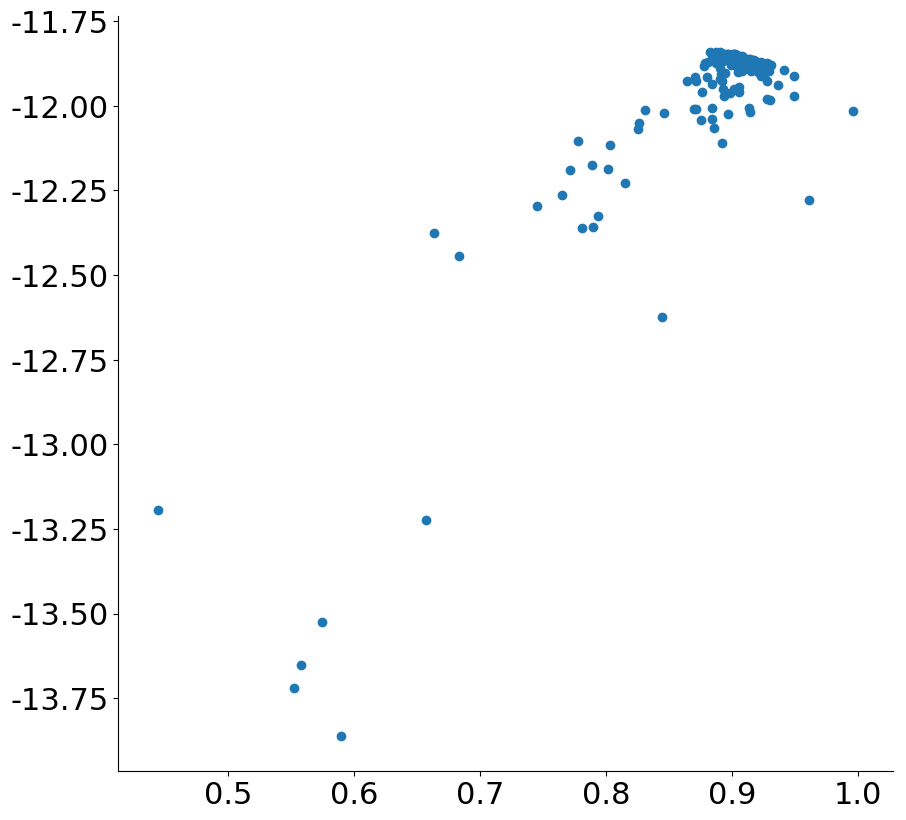

In [311]:
bv = b_photometry - v_photometry
v = v_photometry

plt.scatter(bv, v)